# NewString Clustering Notebook

## 원활한 토크나이징을 위한 mecab 설치

In [16]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [17]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [ ]:
!bash install_mecab-ko_on_colab190912.sh

## 벡터화, 시각화에 필요한 모듈 설치

In [ ]:
!pip install jamo
!pip install top2vec
!pip install umap-learn[plot]

## 모듈 불러오기

In [28]:
# 오류 발생시 4번셀 재 실행후 5번셀 실행
import json
import requests

import umap
import umap.plot
import hdbscan
from top2vec import Top2Vec

from jamo import h2j, j2hcj 
from konlpy.tag import Mecab

## 기사 수집
- key 변수에는 api 키를 입력해주세요

In [2]:
key = "9af2f705-2974-4340-8b55-d69040b944ab"

In [7]:
url = 'http://tools.kinds.or.kr:8888/search/news'

datas = {
    "access_key": key,

    "argument": {
        "query": "",
        "published_at": {
            "from": "2021-09-03",
            "until": "2021-10-13"
            },
            "provider": [""],
            "category": ["008004000"],
            "category_incident": [""],
            "byline": "",
            "provider_subject": [""],
            "subject_info": [""],
            "subject_info1": [""],
            "subject_info2": [""],
            "subject_info3": [""],
            "subject_info4": [""],
            "sort": {"date": "asc"},
            "hilight": 200,
            "return_from": 0,
            "return_size": 10000,
            "fields": [
                "byline",
                "category",
                "category_incident",
                "provider_news_id",
                "hilight",
                ]
                }
         }

response = requests.post(url, data=json.dumps(datas))
res=response.json()

In [8]:
total_hits = res['return_object']['total_hits']
print("수집한 기사 수:",total_hits)

수집한 기사 수: 9837


## Top2vec 입력 코퍼스 생성

In [23]:
# api데이터로 코퍼스 생성
def data_loader(res,total_hits):
    global news_ids
    news_ids, titles, hilights ,title_plus_hilights = [], [], [],[]

    sentence_tokenized_text = []

    for i in range(total_hits):
        title = res['return_object']['documents'][i]['title']
        hilight = res['return_object']['documents'][i]['hilight']
        news_id = res['return_object']['documents'][i]['news_id']
        news_ids.append(news_id)
        title_plus_hilight = title +","+ hilight
        title_plus_hilights.append(title_plus_hilight)
    len(title_plus_hilights)

    return title_plus_hilights

## 사용자 사전 추가

In [24]:
# 사용자 사전 구축을 위한 함수
def get_jongsung_TF(sample_text): 
    sample_text_list = list(sample_text) 
    last_word = sample_text_list[-1] 
    last_word_jamo_list = list(j2hcj(h2j(last_word))) 
    last_jamo = last_word_jamo_list[-1] 
    
    jongsung_TF = "T" 
    
    if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']: 
        jongsung_TF = "F" 
    
    return jongsung_TF

In [25]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


In [29]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines() 
    
word_list = ['오징어게임','오징어 게임','넷플릭스','플릭스패트롤'] 
for word in word_list: 
    jongsung_TF = get_jongsung_TF(word) 
    
    line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(word, jongsung_TF, word) 
    
    file_data.append(line)

with open("./user-dic/nnp.csv", 'w', encoding='utf-8') as f: 
    for line in file_data: 
        f.write(line)

with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f: 
    file_new = f.readlines()
file_new

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '오징어게임,,,,NNP,*,T,오징어게임,*,*,*,*,*\n',
 '오징어 게임,,,,NNP,*,T,오징어 게임,*,*,*,*,*\n',
 '넷플릭스,,,,NNP,*,F,넷플릭스,*,*,*,*,*\n',
 '넷플릭스,,,,NNP,*,F,넷플릭스,*,*,*,*,*\n',
 '플릭스패트롤,,,,NNP,*,T,플릭스패트롤,*,*,*,*,*\n']

In [30]:
mecab = Mecab()
news_corpus = data_loader(res, total_hits)

## Top2Vec 모델링
1. 토크나이징 (mecab)
1. doc2vec 벡터화
2. umap 128차원 -> 5차원
3. hdbscan 군집화

In [31]:
# 모델 초기화
model = 0
model = Top2Vec(documents = news_corpus, 
                tokenizer = mecab.morphs,

                umap_args = {'n_neighbors': 15, 
                             'n_components': 5, 
                             'metric': 'cosine', 
                             "random_state": 42},
                
                hdbscan_args = {'min_cluster_size': 15,
                                'metric': 'euclidean',
                                'cluster_selection_method': 'eom'})

2021-10-13 09:48:20,679 - top2vec - INFO - Pre-processing documents for training
2021-10-13 09:48:24,770 - top2vec - INFO - Creating joint document/word embedding
2021-10-13 09:50:03,210 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-10-13 09:50:52,255 - top2vec - INFO - Finding dense areas of documents
2021-10-13 09:50:52,655 - top2vec - INFO - Finding topics


## Top2vec 클러스터 시각화
- 시각화를 위해 2차원 공간으로 축소

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


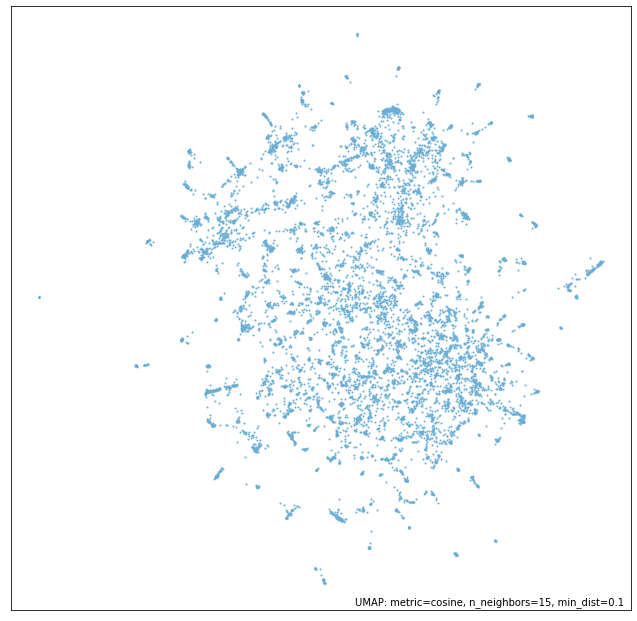

In [32]:
umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}

mapper = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))
umap.plot.points(mapper,)

# Reference
# https://umap-learn.readthedocs.io/en/latest/clustering.html

- 클러스터 시각화

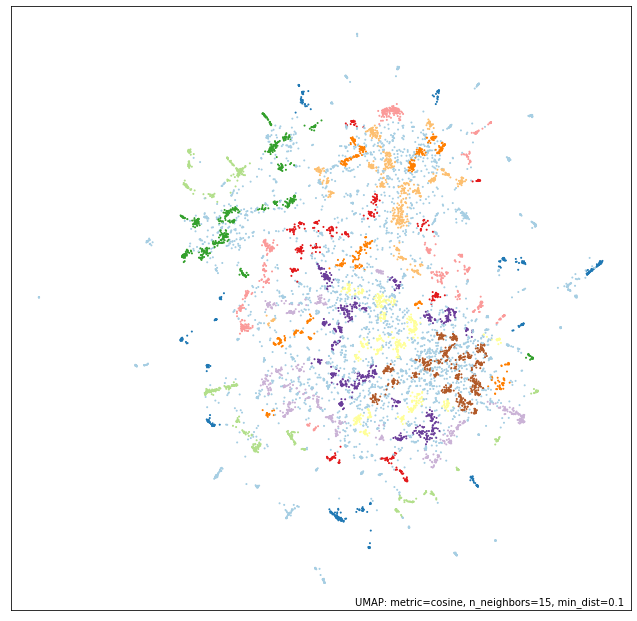

In [33]:
bhdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(mapper.embedding_)
umap.plot.points(mapper,cluster.labels_, color_key_cmap='Paired',show_legend=False)

# Reference
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

## 군집수 확인

In [34]:
model.get_num_topics()

187

## 각 군집 크기 확인

In [54]:
topic_words, word_scores, topic_nums = model.get_topics()
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([242, 235, 152, 144, 142, 127, 126, 123, 118, 118, 106, 106, 105,
       104, 102,  98,  97,  97,  95,  93,  92,  88,  87,  83,  77,  75,
        74,  73,  73,  73,  72,  71,  71,  71,  71,  70,  69,  68,  68,
        68,  67,  66,  63,  63,  63,  62,  62,  60,  60,  60,  60,  59,
        57,  57,  57,  56,  56,  55,  55,  54,  54,  53,  53,  53,  53,
        52,  52,  52,  51,  50,  49,  49,  49,  48,  48,  48,  48,  48,
        48,  47,  47,  47,  47,  47,  47,  47,  46,  46,  45,  45,  45,
        45,  44,  43,  43,  43,  43,  43,  42,  42,  42,  42,  42,  42,
        42,  41,  41,  41,  41,  40,  40,  40,  40,  40,  40,  40,  39,
        36,  36,  36,  35,  35,  35,  35,  35,  35,  35,  34,  34,  34,
        34,  34,  33,  33,  33,  32,  32,  32,  32,  31,  31,  31,  31,
        31,  31,  31,  31,  31,  31,  31,  30,  30,  30,  29,  29,  29,
        29,  28,  28,  27,  27,  27,  27,  27,  27,  26,  26,  26,  26,
        25,  25,  24,  24,  24,  24,  24,  23,  23,  23,  22,  2

## 각 군집 키워드 확인
- 상위 10 군집 확인

In [63]:
try:
    for idx in range(model.get_num_topics()):
        kwd = topic_words[idx][:10]
        print(f" {idx}번 군집의 구성 키워드 Top10")
        print(" >>>",kwd)
        print("-"*70)
        print()


        if idx ==10:
            break
except:
    None

 0번 군집의 구성 키워드 Top10
 >>> ['시대' '코로나' '변화' '팬데' '창간' '기고' '믹' '특집' '19' '전반']
----------------------------------------------------------------------

 1번 군집의 구성 키워드 Top10
 >>> ['생각' '살' '사람' '없' '죠' '그' '을까' '지만' '때' '책']
----------------------------------------------------------------------

 2번 군집의 구성 키워드 Top10
 >>> ['플릭스' '패트롤' '순위' '83' '집계' '차지' '개국' '드라마' '오징어' '위']
----------------------------------------------------------------------

 3번 군집의 구성 키워드 Top10
 >>> ['교류' '총장' '산업' '대학교' '협력' '협약' '흥원' '진' '대학' '예술']
----------------------------------------------------------------------

 4번 군집의 구성 키워드 Top10
 >>> ['플립' '폴' '폴드' '더블' '아이폰' '폰' '갤럭시' 'Z' '애플' '접']
----------------------------------------------------------------------

 5번 군집의 구성 키워드 Top10
 >>> ['AWS' 'G' '반도체' '클라우드' '상용' '전사' '실증' '전환' '솔루션' '대한항공']
----------------------------------------------------------------------

 6번 군집의 구성 키워드 Top10
 >>> ['국회' '국정' '의원' '더불' '감사' '국감' '민주당' '개정안' '위원회' '제도']
------------------

## 군집 내부 기사 확인
- 상위 10개 기사

In [46]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=10, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    if score >= 0.4:
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()

Document: 4177, Score: 0.8560961484909058
-----------
위기의 엔씨, 야심작 리니지W 띄우기 사활,위기의 엔씨, 야심작 리니지W 띄우기 사활 엔씨소프트가 신작 MMORPG(다중접속역할수행게임) ..'리니지W' 띄우기에 총력을 기울이고 있다... 국내에서는 2차 온라인 쇼케이스를 열고 해외에서는 일본 도쿄게임쇼에 참가해 리니지W를 공개한다... 지나친 과금 유도 정책과 잇단 소통 부재로 최근 위기에 내몰리고 있는 엔씨소프트가 기대작 리니지W로 환골탈태..
-----------

Document: 6626, Score: 0.8304732441902161
-----------
엔씨소프트, 신작 '리니지W' 확률형아이템 배제,엔씨소프트, 신작 ..'리니지W' 확률형아이템 배제 엔씨소프트가 신작 ..'리니지W'에 확률형 아이템을 적용하지 않는다... 확률형 아이템 매출에 의존하면서 비과금 이용자를 차별하는 기존 리니지식 비즈니스모델(BM)의 변화를 예고했다. .. ..엔씨소프트는 11월 4일 출시하는 리니지W'에 ..'아인하사드 시스템' 같은 유료형 강화효과 아이템(버프)을 ..
-----------

Document: 1680, Score: 0.8289632797241211
-----------
린저씨도 절레절레…흔들리는 엔씨, 자사주 약발 없었다,린저씨도 절레절레…흔들리는 엔씨, 자사주 약발 없었다 엔씨소프트가 흔들리고 있다... 신작 블레이드&소울2(블소2)가 흥행에 실패하고, 과도한 과금문제로 ..'린저씨(리니지+아저씨·열성 리니지 이용자)'마저 떠나가고 있기 때문이다... 자사주 매입이라는 강수도 뒀지만 시장은 냉랭하기만 하다... 증권가에선 리니지W의 흥행여부가 당분간 엔씨소프트에 있어 ..
-----------

Document: 6575, Score: 0.824897050857544
-----------
엔씨 ‘리니지W’ 과금 구조 개편… 리니지M 아인하사드도 손봐,엔씨 ..‘리니지W’ 과금 구조 개편… 리니지M 